# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
!pip install lightgbm
import lightgbm as lgbm
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from catboost import CatBoostRegressor, cv, train
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv(r'C:\Users\kuzmi\Downloads\autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Удалим столбцы, которые не влияют на цену, или влияют очень мало. Также удалим столбец фото, т.к. там все по нулям.

In [5]:
data.corr()['Price'].sort_values()

Kilometer           -0.333199
RegistrationYear     0.026916
PostalCode           0.076055
RegistrationMonth    0.110581
Power                0.158872
Price                1.000000
NumberOfPictures          NaN
Name: Price, dtype: float64

In [6]:
data = data.drop(['RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [7]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


### Price

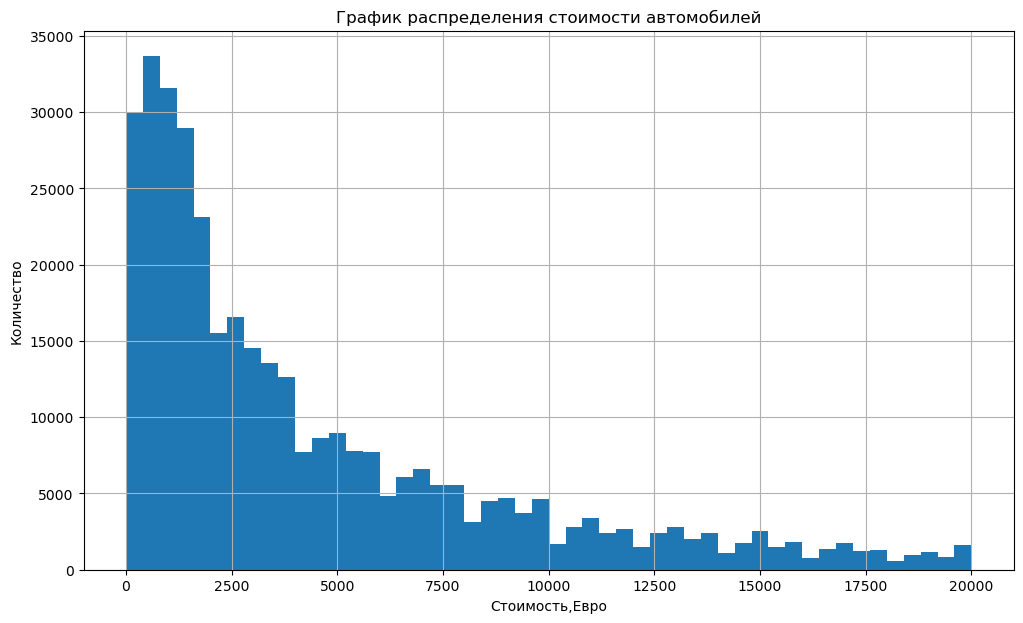

In [8]:
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

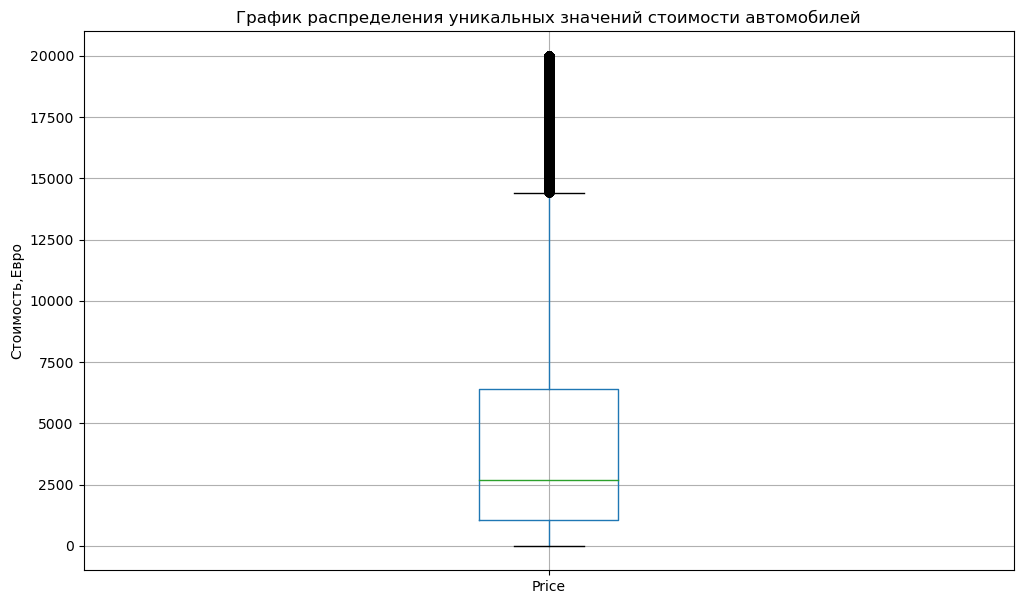

In [9]:
data.boxplot(['Price'],figsize=(12,7))
plt.title('График распределения уникальных значений стоимости автомобилей')

plt.ylabel('Стоимость,Евро')
plt.show()

Удалю цены выше 14000, т.к. это выбросы

In [10]:
data = data.loc[data['Price'] < 14000]

In [11]:
len(data.loc[data['Price'] == 0])

10772

In [12]:
data = data.loc[data['Price'] != 0]

### VehicleType

In [13]:
data['VehicleType'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'wagon', 'bus',
       'coupe', 'other'], dtype=object)

In [14]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

### RegistrationYear

In [15]:
data.DateCrawled.max()

'2016-04-07 14:36:58'

In [16]:
data = data.query('RegistrationYear >= 1950 & RegistrationYear < 2017')

### Gearbox

In [17]:
data['Gearbox'].isna().sum()

15256

Пропусков менее 10% - удаляем

In [18]:
data.dropna(subset=['Gearbox'], inplace=True)

In [19]:
data['Gearbox'].isna().sum()

0

### Power

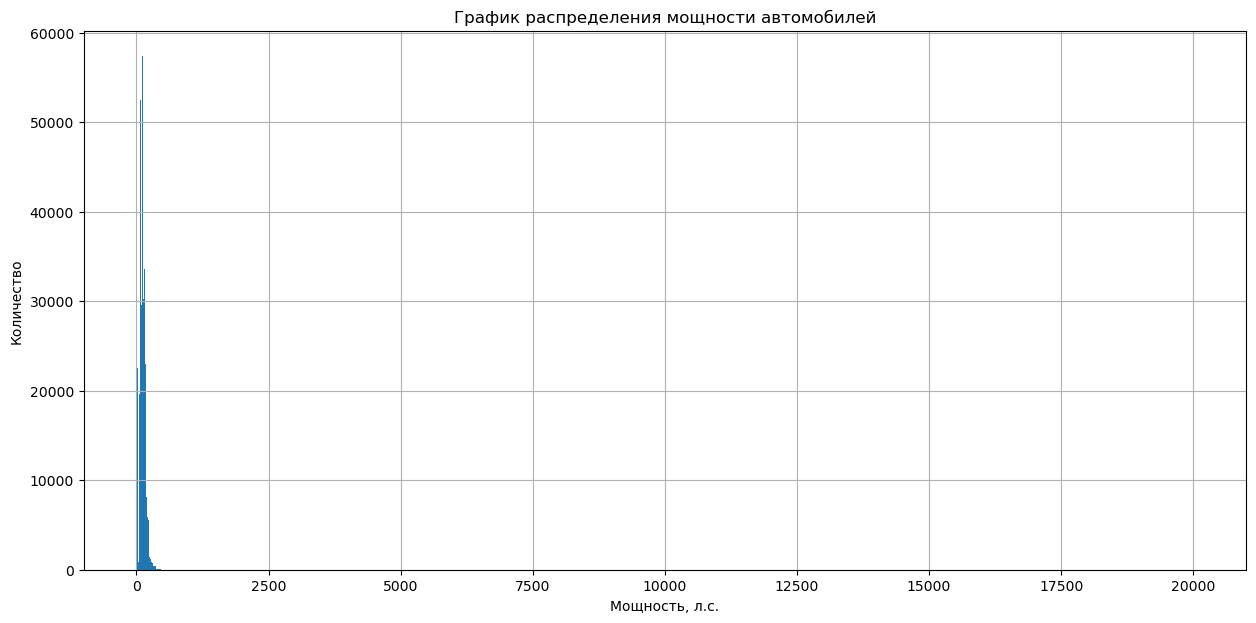

In [20]:
data['Power'].hist(figsize=(15,7), bins=1000)
plt.title('График распределения мощности автомобилей')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество')
plt.show()

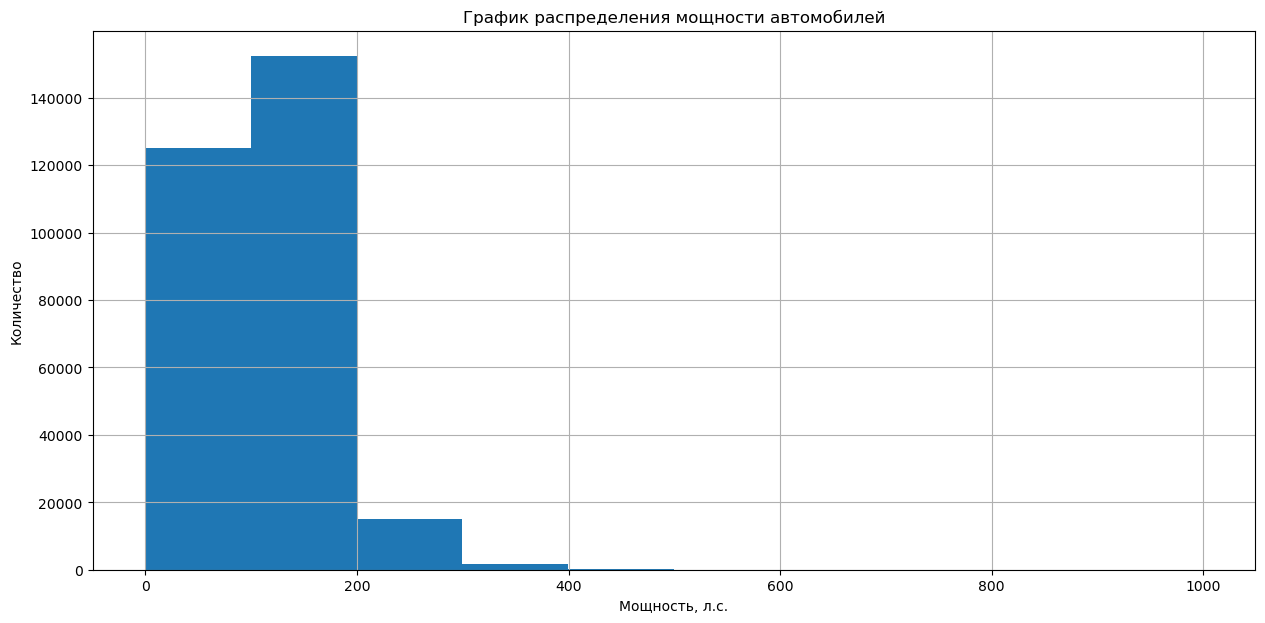

In [21]:
data['Power'].loc[data['Power'] < 1000].hist(figsize=(15,7))
plt.title('График распределения мощности автомобилей')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество')
plt.show()

In [22]:
data['Power'].unique()

array([    0,   163,    75,    69,   102,   109,   101,   105,   140,
         115,   131,   136,   160,   231,    50,   118,   193,    99,
          60,   113,   122,   129,    70,   306,    95,    61,   177,
          55,   143,   286,   232,   150,   156,    80,    82,    90,
         155,    54,   185,    87,   180,    84,   125,   224,   235,
         200,   178,   265,    77,   110,   144,    86,   120,   170,
         116,   184,   126,   204,    88,   194,    64,   197,   179,
         250,    45,   165,    98,   218,    41,   130,   114,    56,
         201,    58,   107,   174,   100,   220,    73,   192,    68,
          66,    74,    52,   147,   310,    71,    97,    65,   203,
           5,   300,   103,    85,   258,    63,    81,   148,    44,
          83,   145,   280,   190,   260,   104,   299,   188,   333,
         186,   117,   141,   132,   234,   158,    39,    92,    51,
         135,    59,   230,    53,   209,   239,    43,   211,    67,
         106,   166,

In [23]:
data=data.query('Power > 30 & Power < 500')

### Model

In [24]:
data['Model'].isna().sum()

9744

Менее 10% - удаляем

In [25]:
data.dropna(subset=['Model'], inplace=True)

### Kilometer

In [26]:
data.Kilometer.describe()

count    261472.000000
mean     130925.089493
std       34317.988512
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

### FuelType

In [27]:
data['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261472 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       261472 non-null  object
 1   Price             261472 non-null  int64 
 2   VehicleType       261472 non-null  object
 3   RegistrationYear  261472 non-null  int64 
 4   Gearbox           261472 non-null  object
 5   Power             261472 non-null  int64 
 6   Model             261472 non-null  object
 7   Kilometer         261472 non-null  int64 
 8   FuelType          249838 non-null  object
 9   Brand             261472 non-null  object
 10  Repaired          225371 non-null  object
dtypes: int64(4), object(7)
memory usage: 23.9+ MB


In [29]:
data['FuelType'].isna().sum()

11634

In [30]:
data.dropna(subset=['FuelType'],inplace=True)

Gasoline и petrol - бензин, который называется так в разных странах, заменим эти значения на одно

In [31]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'gas/petrol').replace('petrol', 'gas/petrol')

In [32]:
data['FuelType'].unique()

array(['gas/petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Brand

In [33]:
data['Brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'mazda',
       'renault', 'ford', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'mini', 'smart', 'audi', 'nissan', 'opel', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'hyundai', 'suzuki', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'jaguar', 'daewoo', 'rover', 'porsche', 'saab', 'land_rover',
       'trabant', 'lada'], dtype=object)

### Repaired

In [34]:
data['Repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [35]:
data['Repaired'].isna().sum()

31930

In [36]:
data['Repaired']=data['Repaired'].fillna('N/A')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249838 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       249838 non-null  object
 1   Price             249838 non-null  int64 
 2   VehicleType       249838 non-null  object
 3   RegistrationYear  249838 non-null  int64 
 4   Gearbox           249838 non-null  object
 5   Power             249838 non-null  int64 
 6   Model             249838 non-null  object
 7   Kilometer         249838 non-null  int64 
 8   FuelType          249838 non-null  object
 9   Brand             249838 non-null  object
 10  Repaired          249838 non-null  object
dtypes: int64(4), object(7)
memory usage: 22.9+ MB


In [38]:
data = data.drop('DateCrawled', axis=1)

### Пропуски

In [39]:
data = data.fillna('unknown')

### Дубликаты

In [40]:
data = data.drop_duplicates()

### Удаляем индексы

In [41]:
data = data.reset_index(drop=True)

### Разделим данные на выборки

In [42]:
category_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'Repaired']
number_features = ['RegistrationYear', 'Power', 'Kilometer']

In [43]:
features = data.drop(['Price'],axis=1)
target = data['Price']

In [44]:
features_ohe = pd.get_dummies(features, columns=category_features, drop_first=True)
features_ohe.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gas/petrol,FuelType_hybrid,FuelType_lpg,FuelType_other,Repaired_no,Repaired_yes
0,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,2008,69,90000,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1995,102,150000,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,2004,109,150000,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [45]:
features_80, features_test, target_80, target_test = train_test_split(
    features_ohe, target, test_size=.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_80, target_80, test_size=.25, random_state=12345)
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((127696, 304), (127696,), (42566, 304), (42566,), (42566, 304), (42566,))

In [46]:
scaler = StandardScaler()

scaler.fit(features_train[number_features])
scaler.fit(features_valid[number_features])
scaler.fit(features_test[number_features])

features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

features_train[number_features] = scaler.transform(features_train[number_features])
features_valid[number_features] = scaler.transform(features_valid[number_features])
features_test[number_features] = scaler.transform(features_test[number_features])

features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gas/petrol,FuelType_hybrid,FuelType_lpg,FuelType_other,Repaired_no,Repaired_yes
16720,0.229909,-0.770046,0.580035,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
75890,-0.265007,2.036746,-1.707909,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
21163,1.549686,-0.648011,-2.851881,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
155960,1.219742,-0.627672,-1.707909,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
200419,0.229909,0.958775,0.580035,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Вывод

1. Из данных удалены или заменены ненужные значения, дубликаты и выбросы.
2. Категориальные признаки преобразованы с помощью one-hot encoding.
3. Признак с большим колличеством категорий закодирован техникой Ordinal Encoding.
4. Данные разделены на тестовую и обучающую выборки и стандартизированны


## Обучение моделей

In [47]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

### Linear Regression

In [48]:
%%time
lmodel = LinearRegression()
lmodel.fit(features_train, target_train)

Wall time: 3.61 s


LinearRegression()

In [49]:
%%time
preds_lmodel = lmodel.predict(features_valid)

Wall time: 107 ms


In [50]:
mse_lmodel = mean_squared_error(target_test, preds_lmodel)
print("RMSE для линейной модели на тестовой выборке:", round((mse_lmodel) ** 0.5, 2))

RMSE для линейной модели на тестовой выборке: 4526.09


### DecisionTreeRegressor

1551.4334428360282

16

Wall time: 22.6 s


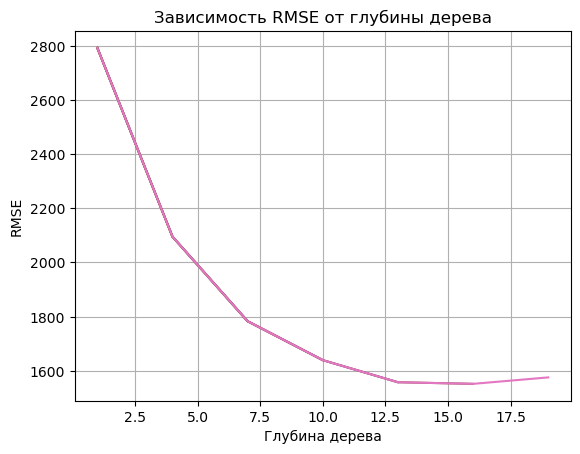

In [51]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 3):
    model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_dtr.fit(features_train, target_train)
    predictions_valid = model_dtr.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)
        
    plt.plot(depths, results)
    plt.title("Зависимость RMSE от глубины дерева")
    plt.xlabel("Глубина дерева")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

### CatBoostRegressor

0:	learn: 2813.8856674	total: 163ms	remaining: 4.73s
5:	learn: 2325.9417184	total: 228ms	remaining: 912ms
10:	learn: 2120.9071061	total: 290ms	remaining: 501ms
15:	learn: 2020.3162531	total: 358ms	remaining: 313ms
20:	learn: 1942.4169950	total: 434ms	remaining: 186ms
25:	learn: 1884.1982196	total: 498ms	remaining: 76.5ms
29:	learn: 1857.6105265	total: 545ms	remaining: 0us
0:	learn: 2168.2908983	total: 35.7ms	remaining: 1.03s
5:	learn: 1659.6036944	total: 222ms	remaining: 889ms
10:	learn: 1557.1609067	total: 370ms	remaining: 640ms
15:	learn: 1506.0795549	total: 510ms	remaining: 446ms
20:	learn: 1473.4990336	total: 647ms	remaining: 277ms
25:	learn: 1444.5834019	total: 786ms	remaining: 121ms
29:	learn: 1428.8561854	total: 901ms	remaining: 0us
0:	learn: 1915.1842318	total: 108ms	remaining: 3.14s
5:	learn: 1507.6225056	total: 630ms	remaining: 2.52s
10:	learn: 1426.6991988	total: 1.17s	remaining: 2.02s
15:	learn: 1389.4823288	total: 1.72s	remaining: 1.51s
20:	learn: 1356.4195504	total: 2.24s

1383.082019270759

16

Wall time: 1min


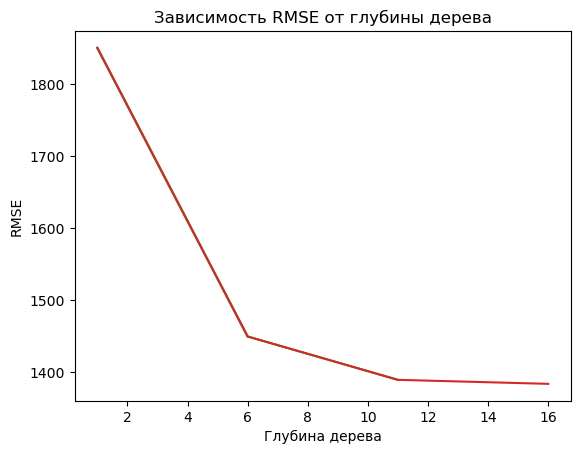

In [52]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 5):
    model_cb = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=depth, random_state=12345, verbose=5)
    model_cb.fit(features_train, target_train)
    predictions_valid = model_cb.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)

    plt.plot(depths, results)
    plt.title("Зависимость RMSE от глубины дерева")
    plt.xlabel("Глубина дерева")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

### LGBMRegressor

In [53]:
%%time

regressor = LGBMRegressor() 
hyperparams = {'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
Wall time: 2min 39s


In [54]:
%%time

model_lgbm = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=19072020)
model_lgbm.fit(features_train, target_train)

Wall time: 5.2 s


LGBMRegressor(num_leaves=200, random_state=19072020)

In [55]:
%%time

target_predict = model_lgbm.predict(features_valid)

Wall time: 537 ms


In [56]:
final_RMSE_LGBMR = mean_squared_error(target_valid, target_predict) ** 0.5
final_RMSE_LGBMR

1310.0064952722998

## Вывод

- Линейная регрессия RMSE - 4526, время - 248ms
- DecisionTreeRegressor с глубиной 16: RMSE - 1551, время - 27.2s
- CatBoost с глубиной 16: RMSE - 1383, время - 1min.11s
- LightGBM c 200 листьями: RMSE - 1310, за время 634ms

Лучше всего показала себя модель LightGBM, ее будем проверять на тестовой выборке

## Анализ моделей

In [57]:
%%time

target_predict = model_lgbm.predict(features_test)

Wall time: 590 ms


In [58]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_LGBMR

1307.0337976333358

### Вывод

Лучше всего предсказывает модель LGBMRegressor, ее рекомендовано использовать